# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>


### Python Dependencies


In [12]:
import numpy as np
from numpy import *

from numpy.linalg import *

from scipy.linalg import *

from scipy.integrate import *
from scipy.signal import *



import matplotlib.pyplot as plt

from matplotlib.pyplot import *

from matplotlib import patches

# Step 1 - Scooter Planar Model


### Introduction


We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

- The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

- Two fixed wheels (their orientation with respect to the frame does not change).
  They are parallel and located at opposite ends of the frame.

Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

- $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
- $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

- $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.


### Parameter Definition


From now on, we assume that the seat frame length is $\ell = 50 \mbox{cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.


In [13]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.


In [14]:
def draw_scooter(x, y, theta):

    xr = x + np.sin(theta) * l / 2  # Calculate x-coordinate of the right wheel
    yr = y - np.cos(theta) * l / 2  # Calculate y-coordinate of the right wheel

    xl = x - np.sin(theta) * l / 2  # Calculate x-coordinate of the left wheel
    yl = y + np.cos(theta) * l / 2  # Calculate y-coordinate of the left wheel

    # Wheel dimensions
    wheel_diameter = 2 * r
    wheel_width = 0.1

    # Create the right wheel rectangle
    right_wheel = patches.Rectangle(
        (x - r, y - l / 2 - wheel_width),  # Bottom-left corner
        wheel_diameter,
        wheel_width,
        angle=np.degrees(theta),
        edgecolor="black",
        facecolor="black",
        rotation_point=(x, y),
        linewidth=2,
    )

    # Create the right wheel rectangle
    left_wheel = patches.Rectangle(
        (x - r, y + l / 2),  # Bottom-left corner
        wheel_diameter,
        wheel_width,
        angle=np.degrees(theta),
        edgecolor="black",
        facecolor="black",
        rotation_point=(x, y),
        linewidth=1,
    )

    # Plot the scooter's center
    plt.plot(
        x + 0.5 * np.cos(theta), y + 0.5 * np.sin(theta), "go"
    )  # Plot the scooter's center as a green dot

    # Define the polygon for the scooter body right part
    patch_r = patches.Polygon(
        [
            (x, y),  # Center point
            (
                xr - r * np.cos(theta),
                yr - r * np.sin(theta),
            ),  # Right top point
            (
                xr + r * np.cos(theta),
                yr + r * np.sin(theta),
            ),  # Right bottom point
        ],
        closed=True,
        edgecolor="red",  # Red edge color
        facecolor="red",  # Red face color
    )
    # Define the polygon for the scooter body right part
    patch_l = patches.Polygon(
        [
            (x, y),  # Center point
            (
                xl - r * np.cos(theta),
                yl - r * np.sin(theta),
            ),  # Right top point
            (
                xl + r * np.cos(theta),
                yl + r * np.sin(theta),
            ),  # Right bottom point
        ],
        closed=True,
        edgecolor="red",  # Red edge color
        facecolor="red",  # Red face color
    )


    ax = plt.gca()
    ax.add_patch(right_wheel)  # Add the right wheel rectangle to the plot
    ax.add_patch(left_wheel)  # Add the left wheel rectangle to the plot
    ax.add_patch(patch_r)  # Add the right body polygon to the plot
    ax.add_patch(patch_l)  # Add the left body polygon to the plot
    plt.axis("equal")

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.


In [15]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax + 1, 1))
    yticks(arange(ymin, ymax + 1, 1))
    grid(True)

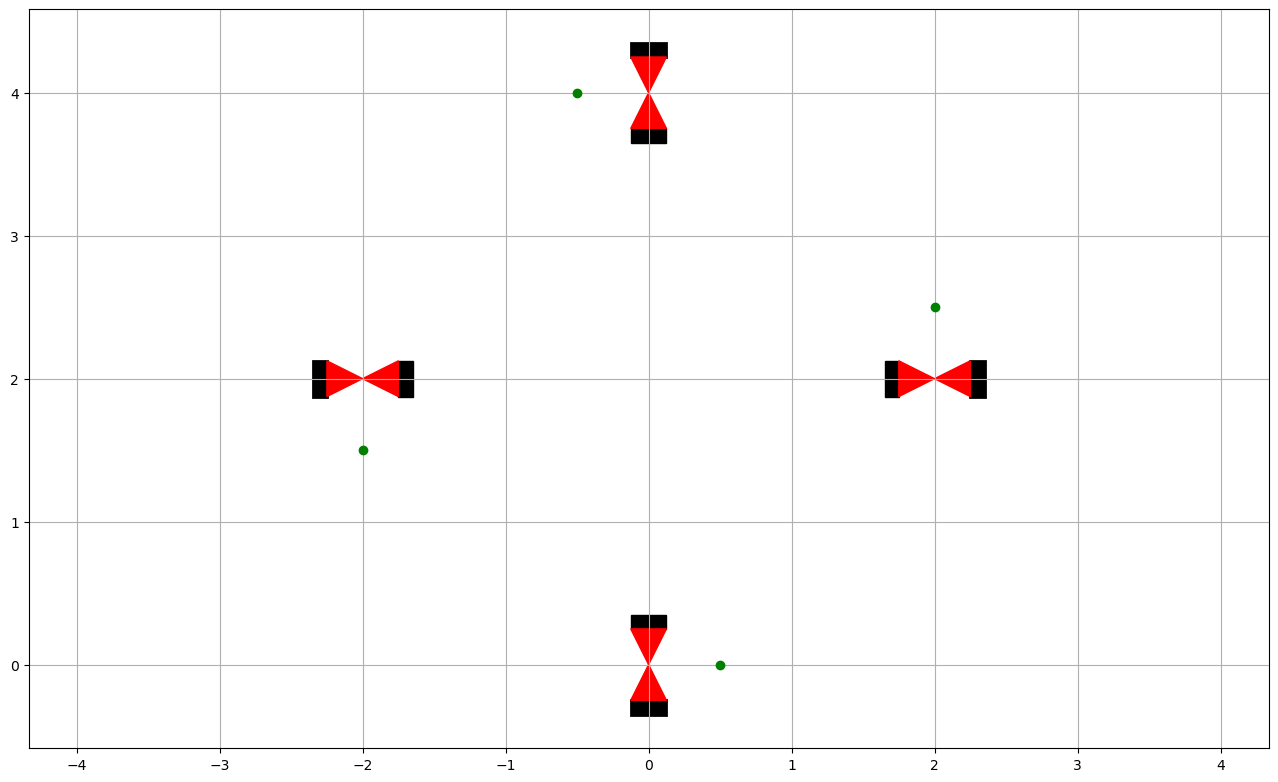

In [16]:
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, np.pi / 2)
draw_scooter(0, 4, np.pi)
draw_scooter(-2, 2, 3 * np.pi / 2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a _kinematic_ model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.


In [17]:
omega_l = 2
omega_r = 2
theta = 0

# v = (vl+vr) /2 =(r * (omega_l + omega_r) ) / 2.0
v = r * (omega_l + omega_r) / 2.0
omega = r * (omega_r - omega_l) / l

x_dot = v * np.cos(theta)
y_dot = v * np.sin(theta)
theta_dot = omega

**TODO**


### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.


On a $\theta$ ppint, $x$point et $ypoint$ sont des fonctions de $wl$, $wr$ et $\theta$ (d'après les équations ci-dessus). Comme $wr$, $wl$ sont des fonctions continues différentiables, alors $\theta$point, $x$point, $y$point sont continues et différentiables. Ainsi le système est bien posé.

**TODO**


🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?


**TODO**


### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:


In [18]:
def omega(t, xytheta):
    omega_l = (1 - l / 4) * pi / r
    omega_r = (1 + l / 4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).


In [19]:
def fun(t,xytheta):
    omega2=omega(t,xytheta)
    x, y, theta = xytheta
    omega_l=omega2[0]
    omega_r=omega2[1]
    v = r * (omega_l + omega_r) / 2

    theta_dot = r * (omega_r - omega_l) / l
    x_dot = v * np.cos(theta)
    y_dot = v * np.sin(theta)
    return array([x_dot, y_dot,theta_dot])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)



In [20]:
import numpy as np
from scipy.integrate import solve_ivp


x0, y0, theta0 = 0.0, 0.0, 0.0
initial_state = np.array([x0, y0, theta0])

t_span = (0.0, 4.0)


solution = solve_ivp(fun, t_span, initial_state, dense_output=True)

t_eval = np.linspace(0.0, 4.0, 100)
state_trajectory = solution.sol(t_eval)


x_trajectory = state_trajectory[0]
y_trajectory = state_trajectory[1]
theta_trajectory = state_trajectory[2]

print("x trajectory:", x_trajectory)
print("y trajectory:", y_trajectory)
print("theta trajectory:", theta_trajectory)


x trajectory: [ 0.00000000e+00  1.26847856e-01  2.53184896e-01  3.78508138e-01
  5.02414908e-01  6.24388589e-01  7.43878851e-01  8.60361220e-01
  9.73337082e-01  1.08233368e+00  1.18690413e+00  1.28662739e+00
  1.38110827e+00  1.46997747e+00  1.55289153e+00  1.62953285e+00
  1.69960968e+00  1.76285616e+00  1.81903224e+00  1.86792379e+00
  1.90934249e+00  1.94312589e+00  1.96913742e+00  1.98726636e+00
  1.99742782e+00  1.99956282e+00  1.99363819e+00  1.97964666e+00
  1.95749775e+00  1.92670009e+00  1.88750395e+00  1.84028491e+00
  1.78542152e+00  1.72329529e+00  1.65429071e+00  1.57879523e+00
  1.49719924e+00  1.40989614e+00  1.31728227e+00  1.21975693e+00
  1.11772241e+00  1.01158395e+00  9.01749750e-01  7.88630994e-01
  6.72641820e-01  5.54199336e-01  4.33723614e-01  3.11637695e-01
  1.88367583e-01  6.43422502e-02 -6.00063659e-02 -1.84243362e-01
 -3.07930867e-01 -4.30628047e-01 -5.51891098e-01 -6.71273254e-01
 -7.88324779e-01 -9.02592974e-01 -1.01362217e+00 -1.12095374e+00
 -1.2241260

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.


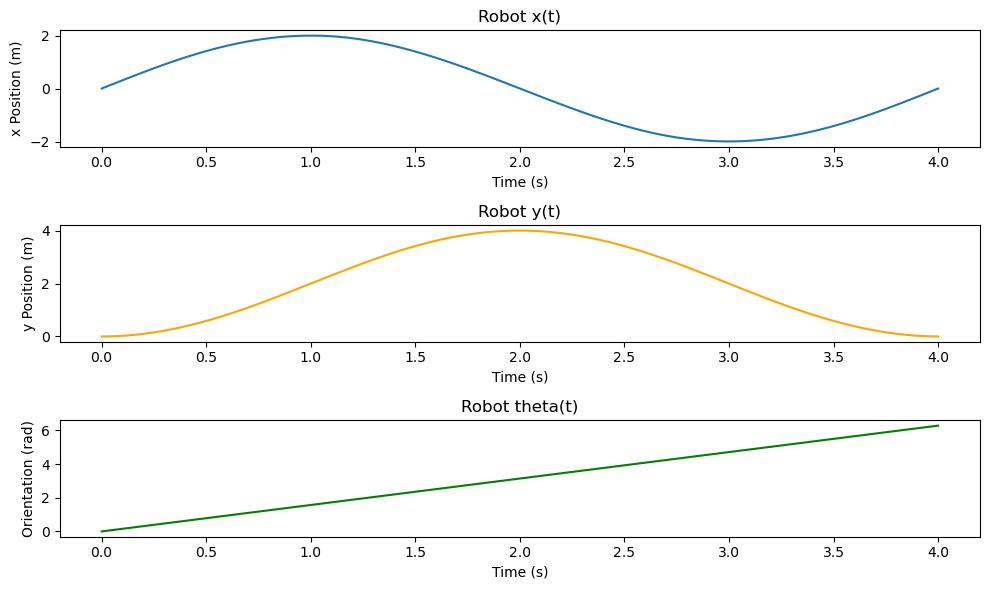

In [23]:
from scipy.integrate import solve_ivp

x0, y0, theta0 = 0.0, 0.0, 0.0
initial_state = np.array([x0, y0, theta0])

t_span = (0.0, 4.0)


solution = solve_ivp(fun, t_span, initial_state, dense_output=True)


t_eval = np.linspace(0.0, 4.0, 100)
state_trajectory = solution.sol(t_eval)


x_trajectory = state_trajectory[0]
y_trajectory = state_trajectory[1]
theta_trajectory = state_trajectory[2]


plt.figure(figsize=(10, 6))


plt.subplot(311)
plt.plot(t_eval, x_trajectory, label='x(t)')
plt.xlabel('Time (s)')
plt.ylabel('x Position (m)')
plt.title('Robot x(t)')


plt.subplot(312)
plt.plot(t_eval, y_trajectory, label='y(t)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('y Position (m)')
plt.title('Robot y(t)')


plt.subplot(313)
plt.plot(t_eval, theta_trajectory, label='theta(t)', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Orientation (rad)')
plt.title('Robot theta(t)')


plt.tight_layout()
plt.show()


🧩 Use the simulation results to display the robot location every 0.5 second.


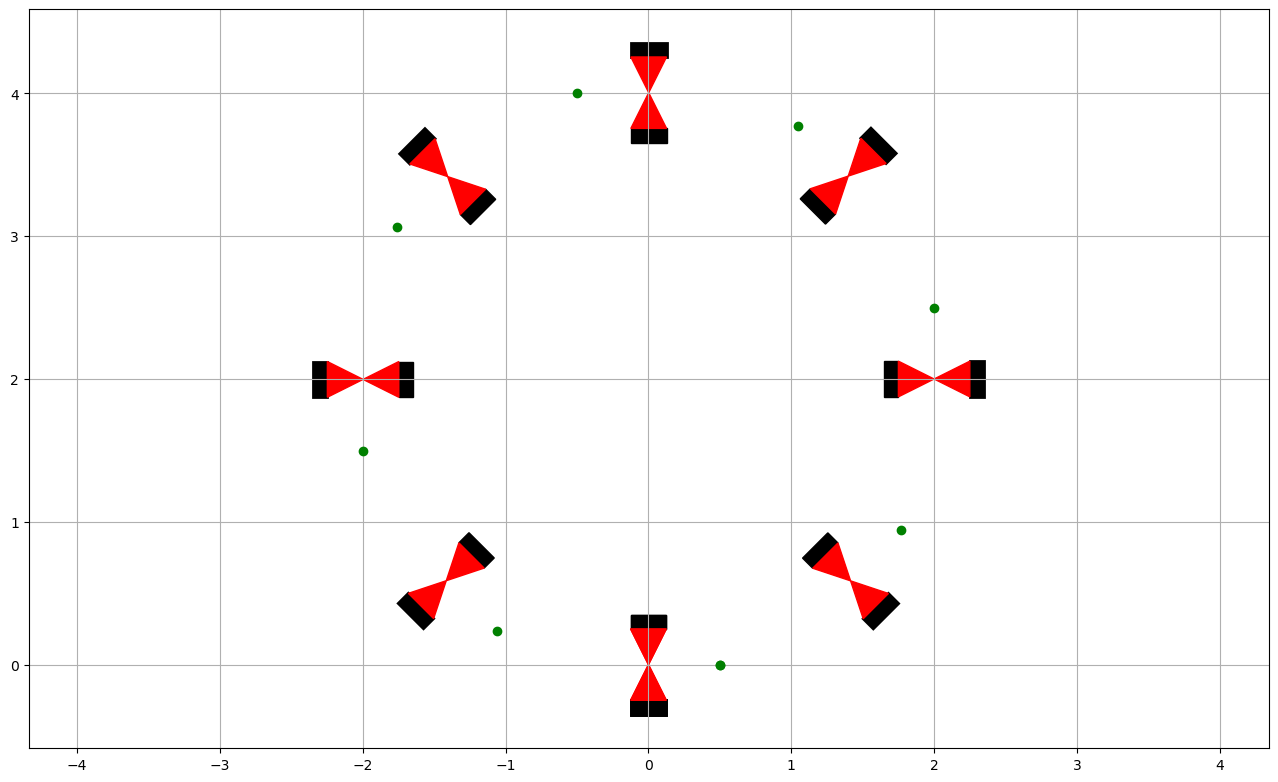

In [28]:
# drawing the world arena

draw_arena(-5, 5, -1, 5)

ts = [i*0.5 for i in range(9)]
for t in ts:
    draw_scooter(solution.sol(t)[0],solution.sol(t)[1],solution.sol(t)[2])

show()

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?


θ(t)= R/L(ωr−ωl)t

x= l/2​(ω l​+ω r​)/(ωr​−ωl​) sin( r/l ​(ωr​−ωl​)t)

y= -l/2​(ω l​+ω r​)/(ωr​−ωl​) cos( r/l​ (ωr​−ωl​)t)

**TODO**


🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.


In [ ]:
t_range = [0.0, 4]
intial_values = [0.0, 0.0, 0.0]
result = solve_ivp(fun=fun, t_span=t_range, y0=intial_values, dense_output = True)

In [ ]:
time = result["t"]
x = result["y"][0]
y = result["y"][1]
theta = result["y"][2]
sol = result["sol"]

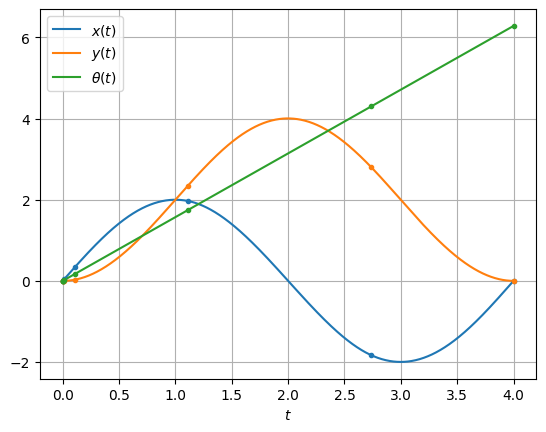

In [ ]:
figure()
t = linspace(0, 4, 1000)
plot(t, sol(t)[0], "-", label="$x(t)$")
plot(t, sol(t)[1], "-", label="$y(t)$")
plot(t, sol(t)[2], "-", label="$ θ(t)$")
plot(time, x, ".", color="C0")
plot(time, y, ".", color="C1")
plot(time, theta, ".", color="C2")
xlabel("$t$"); grid(); legend()

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.


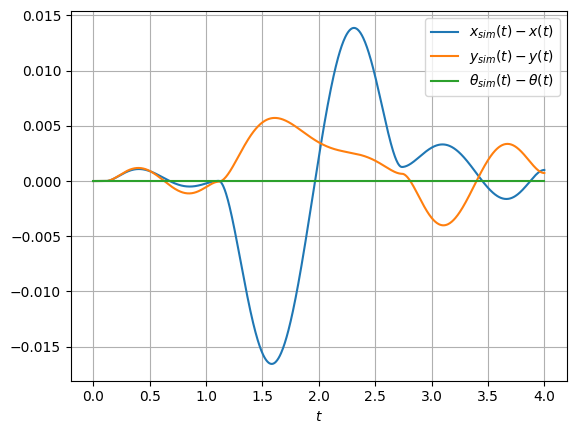

In [ ]:
wl, wr = omega(0, [0,0,0])
def x(t):
    return l/2*(wl + wr)/(wr-wl)*sin(theta(t))
def y(t):
    return  l/2*(wl + wr)/(wr-wl)*(1-cos(theta(t)))
def theta(t):
    return r/l*(wr-wl)*t


figure()
t = linspace(0, 4, 1000)

plot(t, sol(t)[0] - x(t), "-", label="$x_{sim}(t) - x(t)$")
plot(t, sol(t)[1] - y(t), "-", label="$y_{sim}(t) - y(t)$")
plot(t, sol(t)[2] - theta(t), "-", label="$θ_{sim}(t) - θ(t)$")

xlabel("$t$"); grid(); legend()

In [ ]:
result = solve_ivp(fun=fun, t_span=t_range, y0=intial_values, dense_output = True, atol = 1e-6, rtol = 1e-8)
sol = result["sol"]

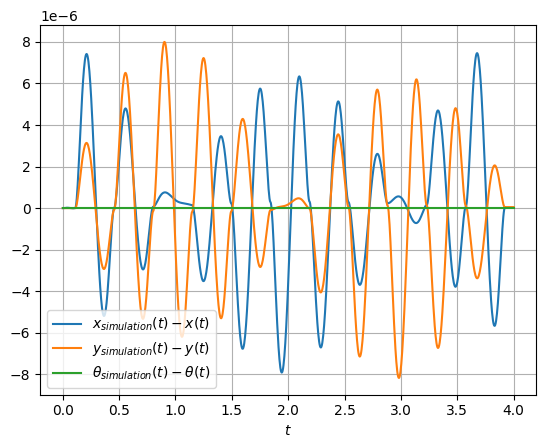

In [ ]:
figure()
t = linspace(0, 4, 1000)

plot(t, sol(t)[0] - x(t), "-", label="$x_{simulation}(t) - x(t)$")
plot(t, sol(t)[1] - y(t), "-", label="$y_{simulation}(t) - y(t)$")
plot(t, sol(t)[2] - theta(t), "-", label="$θ_{simulation}(t) - θ(t)$")

xlabel("$t$"); grid(); legend()